<a href="https://colab.research.google.com/github/JohanSH7/Proyecto_BankMarketing/blob/main/ENTREGA_N%C2%B02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ENTREGABLE N°2 PROYECTO DE AULA**
## **PROBLEMA DE CLASIFICACIÓN "BANK MARKETING"**

Contextualización del problema:

El objetivo es construir un modelo de clasificación que pueda predecir si un cliente se suscribirá o no a un depósito a plazo basándose en las variables seleccionadas previamente despues de haber realizado el analisis y filtrado de variables o caracteristicas relevantes para el modelo.

Se encuentra más información en el siguiente link.

### **Importamos todas las dependencias**

In [68]:
#Importing all the dependencies
%load_ext autoreload
%autoreload 2
in_colab = True
import os
import sys ; sys.path.append('../drive/MyDrive/Colab Notebooks/local/data');
import pandas as pd
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
from scipy import stats
import random
import math
import numpy.matlib
import functools
import scipy.io
import inspect
import time
import requests

from sklearn import tree
from scipy.stats import mode
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, LeaveOneOut, ShuffleSplit, StratifiedKFold
from numpy import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits, load_wine, make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **Importamos los datos preprocesados**

In [55]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)
    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)
    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)

file_id = '1asoShhLYgx4oy9cZCjk8ZuqqFnZBrblh'
output = 'nombre_archivo.csv'
download_file_from_google_drive(file_id, output)
df = pd.read_csv(output)

**Codificamos las variables cualitativas o categoricas**

In [56]:
# Lista de columnas categóricas a codificar
categorical_columns = df.select_dtypes(include=['object']).columns

# Inicializar el codificador de etiquetas
label_encoder = LabelEncoder()

# Iterar sobre cada columna y aplicar la codificación de etiquetas
for columna in categorical_columns:
    df[columna] = label_encoder.fit_transform(df[columna])

**Seperamos los datos de entrada y salida**

In [59]:
x = df.drop(columns=['y'])
y = df['y']

x = np.array(x)
y = np.array(y)


### **Implementamos tecnicas para desbalanceo**

Tener un desbalance de muestras puede ser perjudicial para el proceso de entrenamiento. Vamos a crear una función para verificar el número de muestras por clases

Función que calcula el número de muestras por cada clase:

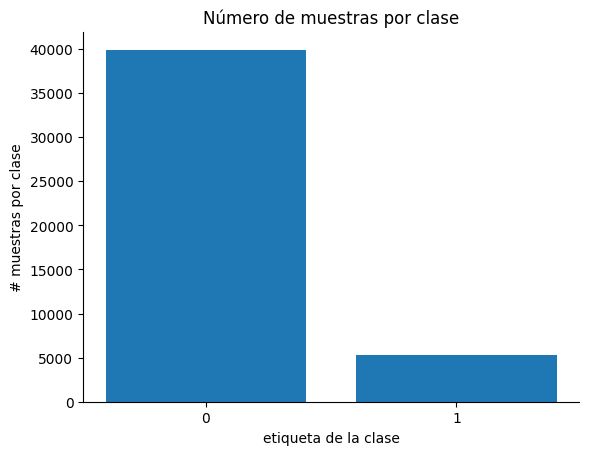

In [60]:
def muestras_por_clases (Y):
    dicto = dict(zip(np.unique(Y,return_counts=True)[0], np.unique(Y,return_counts=True)[1]))
    return (dicto)

fig, ax = plt.subplots()
ax.bar(muestras_por_clases(y).keys(), muestras_por_clases(y).values())
ax.set_title("Número de muestras por clase")
ax.set_xlabel("etiqueta de la clase")
ax.set_ylabel("# muestras por clase")
ax.set_xticks(list(muestras_por_clases(y).keys()))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


**Usamos sobremuestreo (oversampling) inteligente**

In [61]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_oversampled, y_oversampled = oversample.fit_resample(x, y)

X_oversampled = np.array(X_oversampled)
y_oversampled = np.array(y_oversampled)

**Usamos submuestreo (undersampling) inteligente**

In [62]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_subsampled, y_subsampled = undersample.fit_resample(x, y)

X_subsampled = np.array(X_subsampled)
y_subsampled = np.array(y_subsampled)


In [63]:
print('Distribución de clases original %s' % Counter(y))
print('Distribución de clases después de sobremuestreo %s' % Counter(y_oversampled))
print('Distribución de clases después de submuestreo %s' % Counter(y_subsampled))

Distribución de clases original Counter({0: 39921, 1: 5289})
Distribución de clases después de sobremuestreo Counter({0: 39921, 1: 39921})
Distribución de clases después de submuestreo Counter({0: 5289, 1: 5289})


## **MODELO N°1: Decision tree**




In [64]:
def experimentar_dt( X, Y, depths,normalize):
    """funcion que realiza experimentos de arboles de decision
    Args:
        X: matriz con las caractersiticas
        Y: matriz de numpy con etiquetas
        depths: list[int] lista con la profundidad de arboles a experimentar
    normalize str: None, significa nignuna normalización. 'estandar'. 'min-max' los otros dos tipos
    retorna: dataframe con:
        - profunidad de los arboles
        - eficiencia de entrenamiento
        - desviacion de estandar eficiencia de entrenamiento
        - eficiencia de prueba
        - desviacion estandar eficiencia de prueba
    """
    folds = 4
    skf = StratifiedKFold(n_splits=folds)
    resultados = pd.DataFrame()
    idx = 0
    for depth in depths:
        ## para almacenar los errores intermedios
        EficienciaTrain = []
        EficienciaVal = []
        for train, test in skf.split(X, Y):
            Xtrain = X[train,:]
            Ytrain = Y[train]
            Xtest = X[test,:]
            Ytest = Y[test]
            #Normalizamos los datos
            # si la bandera esta en True
            scaler = None
            if normalize == 'estandar':
                #
                scaler = StandardScaler()
                scaler.fit(Xtrain)

            elif normalize == 'min-max':
                #
                scaler = MinMaxScaler()
                scaler.fit(Xtrain)

            else:
                if idx < 1:
                    # solo imprimir la advertencia una vez POR FOLD
                    print("No se ejecuta niguna normalización/estandarización")

            if scaler is not None:
                scaler.fit(Xtrain)
                Xtrain= scaler.transform(Xtrain)
                Xtest = scaler.transform(Xtest)


            #Se crea y entrena el modelo usando los datos de entrenamiento
            modelo = DecisionTreeClassifier(max_depth=depth, criterion="entropy")
            modelo.fit(X=Xtrain,y=Ytrain)
            #predecir muestras de entrenamiento
            Ytrain_pred = modelo.predict(Xtrain)
            #predecir muestras de pruebas
            Ytest_pred = modelo.predict(Xtest)
            #Evaluamos las predicciones del modelo con los datos de test
            EficienciaTrain.append(np.mean(Ytrain_pred.ravel() == Ytrain.ravel()))
            EficienciaVal.append(np.mean(Ytest_pred.ravel() == Ytest.ravel()))

        resultados.loc[idx,'profundidad del árbol'] = depth
        resultados.loc[idx,'eficiencia de entrenamiento'] = np.mean(EficienciaTrain)
        resultados.loc[idx,'std(train)'] = np.std(EficienciaTrain)
        resultados.loc[idx,'eficiencia de prueba'] = np.mean(EficienciaVal)
        resultados.loc[idx,'std(test)'] = np.std(EficienciaVal)
        idx= idx +1

    return resultados


No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalización/estandarización
No se ejecuta niguna normalizac

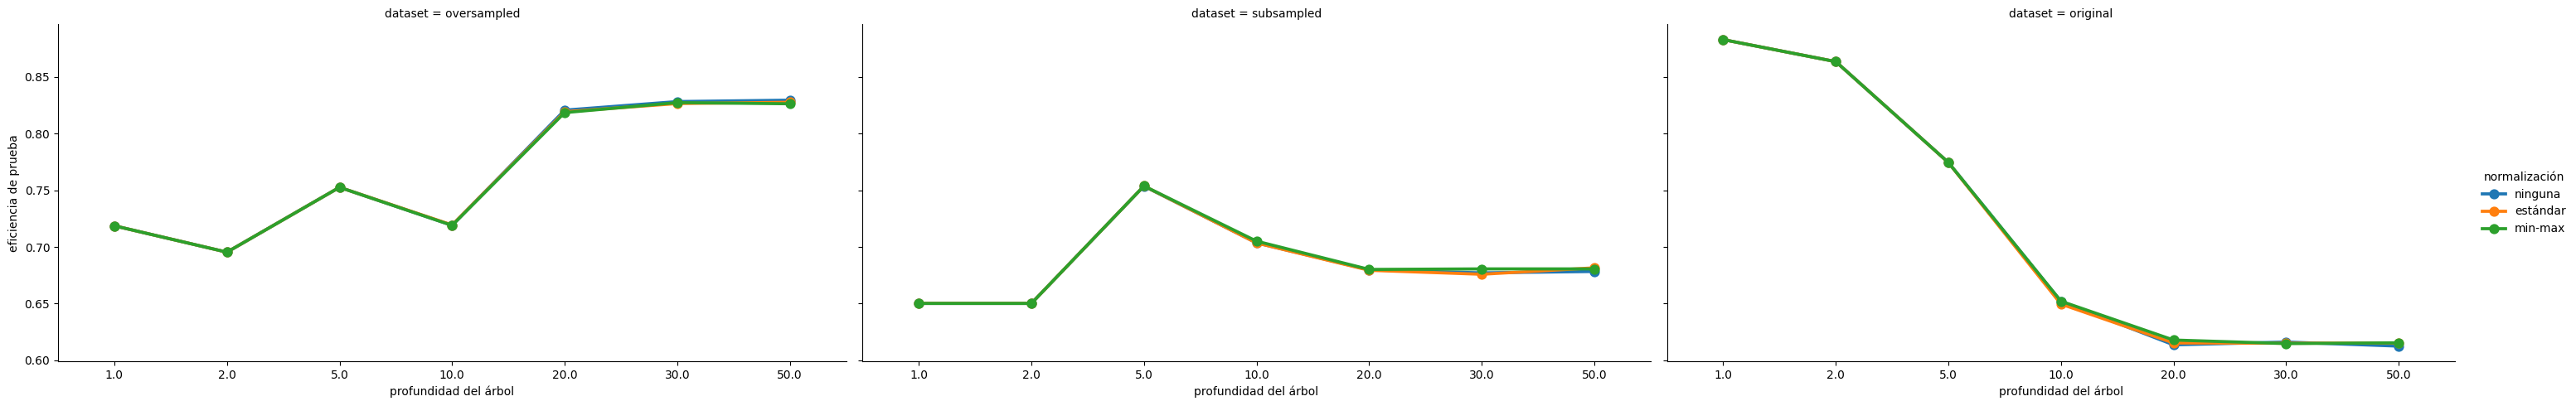

In [66]:
# Realiza los experimentos para observar los efectos
resultados_dt = []
depths = [1,2,5,10,20,30,50]
normalizaciones = ['ninguna', 'estándar', 'min-max']


pairs = [
    (X_oversampled, y_oversampled, 'oversampled'),
    (X_subsampled, y_subsampled, 'subsampled'),
    (x, y, 'original')
]

# Realiza los experimentos y almacena los resultados parciales
resultados_dt = []
depths = [1, 2, 5, 10, 20, 30, 50]
normalizaciones = ['ninguna', 'estándar', 'min-max']

for X, Y, label in pairs:
    for normalize in normalizaciones:
        resultados_parciales = experimentar_dt(X=X, Y=Y, depths=depths, normalize=normalize)
        resultados_parciales['normalización'] = normalize
        resultados_parciales['dataset'] = label
        resultados_dt.append(resultados_parciales)

# Concatena los resultados parciales en un DataFrame
resultados_dt = pd.concat(resultados_dt, ignore_index=True)

# Grafica los resultados
sns.catplot(data=resultados_dt,
            x='profundidad del árbol',
            y='eficiencia de prueba',
            hue='normalización',
            col='dataset',
            kind='point',
            aspect=2)

ccp_alpha = 0.0


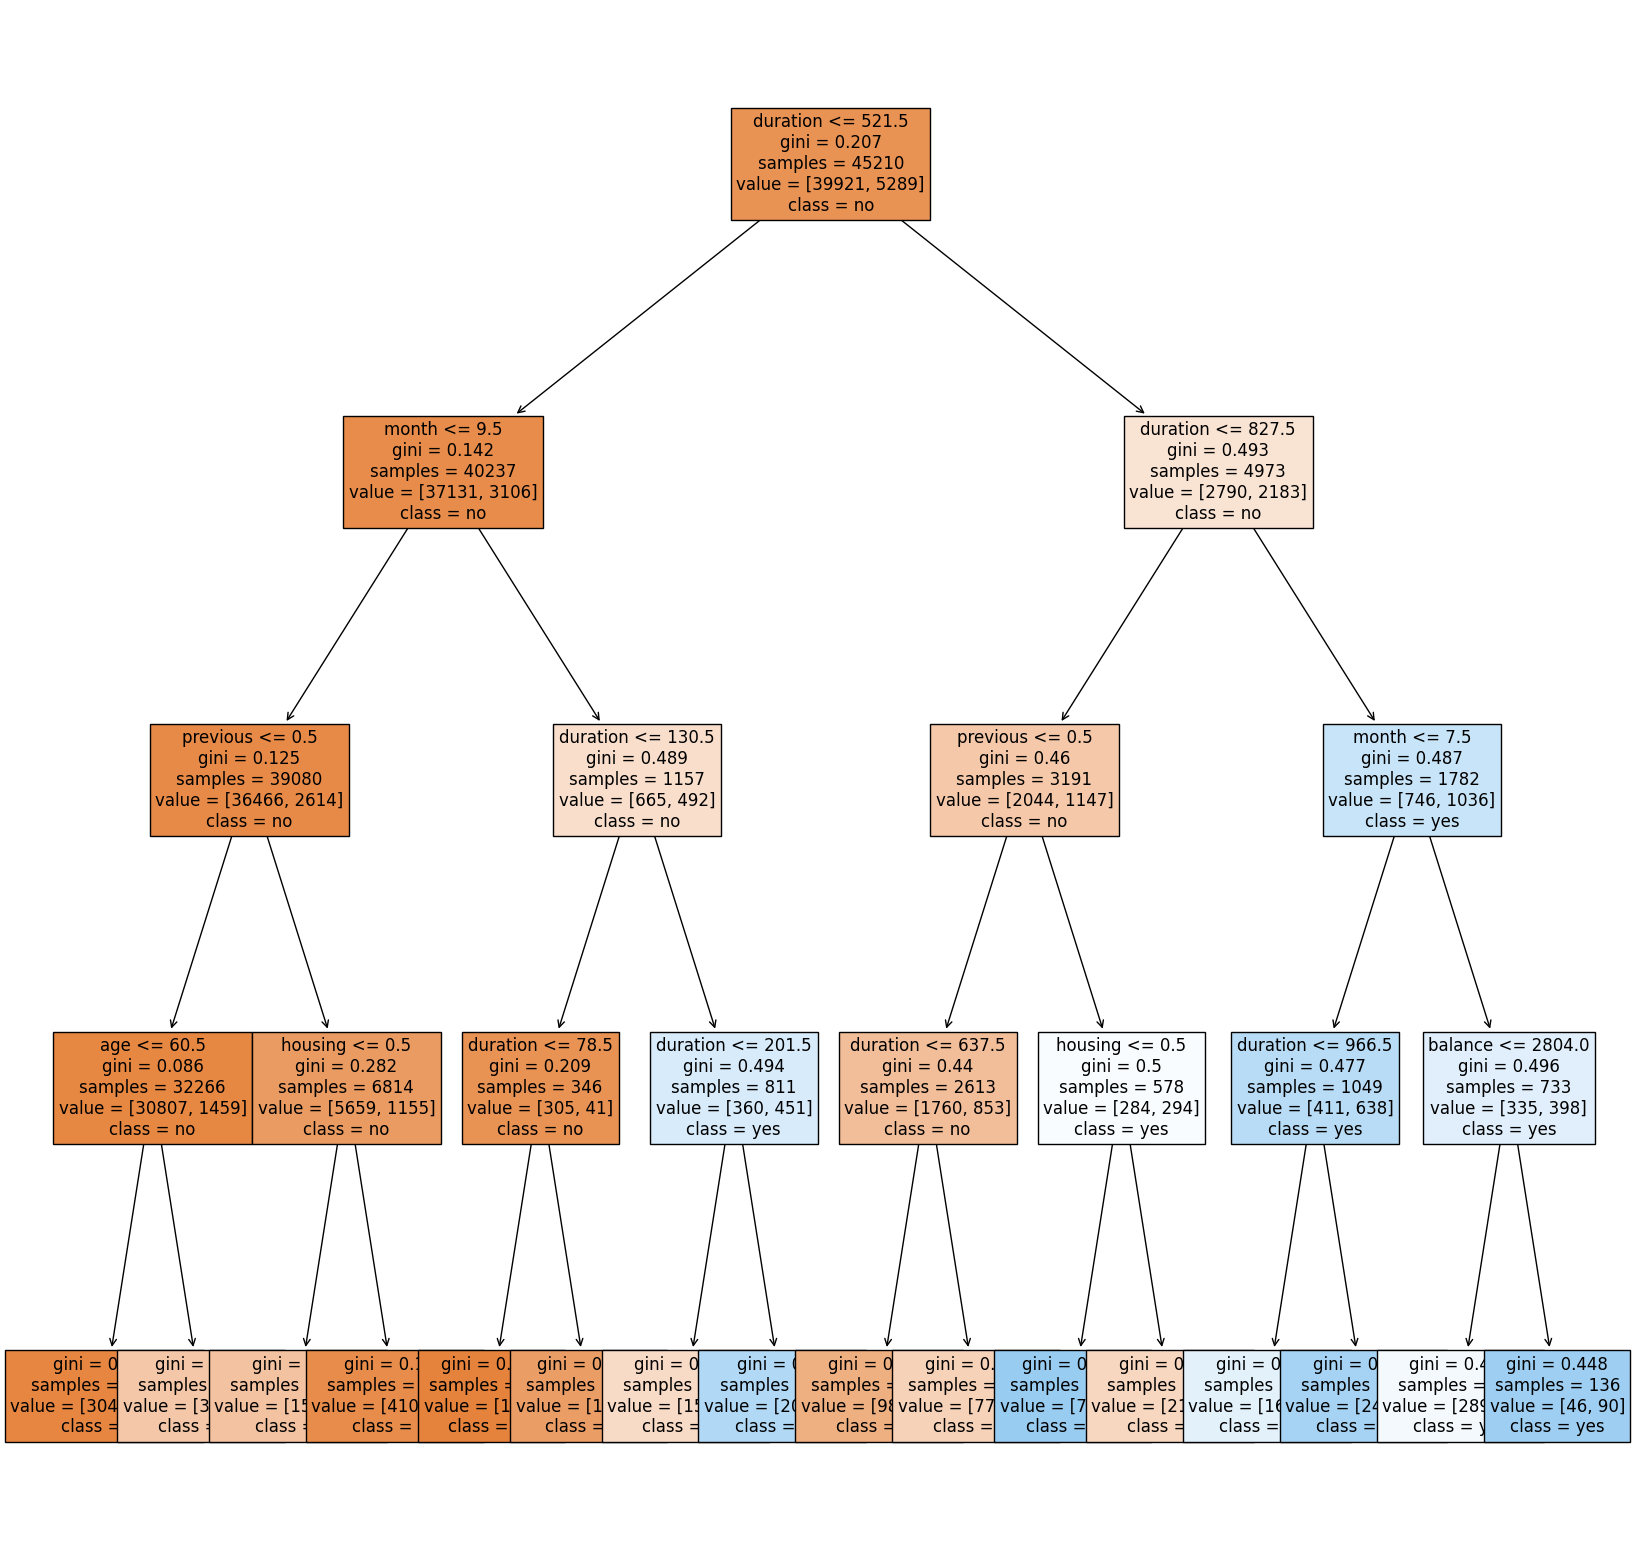

In [69]:
# se usa para visualizar el DT
feature_names = df.columns.to_numpy()
class_names = ['no', 'yes']

modelo = DecisionTreeClassifier(max_depth = 4, criterion="gini", ccp_alpha =0.0)
modelo.fit(x, y)
plt.figure(figsize=(20,20))
tree.plot_tree(modelo,filled = True,class_names = class_names, feature_names=feature_names,fontsize=12)
print("ccp_alpha = 0.0")
plt.show()

In [71]:
# Crear una lista para almacenar los resultados
results = []

# Iterar sobre cada par de arreglos
for X, y, label in pairs:
    # Dividir los datos en conjuntos de entrenamiento y prueba
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

    # Entrenar el modelo
    modelo.fit(x_train, y_train)

    # Predecir en los conjuntos de entrenamiento y prueba
    train_pred = modelo.predict(x_train)
    test_pred = modelo.predict(x_test)

    # Calcular la precisión en los conjuntos de entrenamiento y prueba
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)

    # Calcular la desviación estándar en los conjuntos de entrenamiento y prueba
    train_std = np.std(train_pred == y_train)
    test_std = np.std(test_pred == y_test)

    # Almacenar los resultados en la lista
    results.append((label, train_accuracy, train_std, test_accuracy, test_std))

# Crear un DataFrame de pandas con los resultados
results_df_decision_tree = pd.DataFrame(results, columns=['Dataset', 'eficiencia de entrenamiento', 'Train Std', 'eficiencia de prueba', 'Test Std'])

# Mostrar la tabla
print(results_df_decision_tree)


       Dataset  eficiencia de entrenamiento  Train Std  eficiencia de prueba  \
0  oversampled                     0.795814   0.403106              0.796731   
1   subsampled                     0.788112   0.408646              0.791588   
2     original                     0.896124   0.305100              0.893386   

   Test Std  
0  0.402431  
1  0.406173  
2  0.308621  


## **MODELO N°2: Random Forest**

In [72]:
def experimentar_rf(X, Y, num_trees,numero_de_variables):
    """funcion que realiza experimentos de random forest
    X: matriz con las caractersiticas
    Y: matriz de numpy con etiquetas
    num_trees: list[int]: lista con el número de arboles usado para el RF
    numero_de_variables list[int]: lista con variables para la selección del mejor umbral en cada nodo
    retorna: dataframe con:
        -  numero de arboles usados
        -  variables para la selección del mejor umbral
        - eficiencia de entrenamiento
        - desviacion de estandar eficiencia de entrenamiento
        - eficiencia de prueba
        - desviacion estandar eficiencia de prueba
    """
    folds = 4
    skf = StratifiedKFold(n_splits=folds)
    resultados = pd.DataFrame()
    idx = 0
    for trees in num_trees:
        for num_variables in numero_de_variables:
            ## para almacenar los errores intermedios
            EficienciaTrain = []
            EficienciaVal = []
            for train, test in skf.split(X, Y):
                Xtrain = X[train,:]
                Ytrain = Y[train]
                Xtest = X[test,:]
                Ytest = Y[test]
                #llamado a la función para crear el modelo
                modelo = RandomForestClassifier(n_estimators=trees, max_features=num_variables, random_state=42)
                #entrenando..
                modelo.fit(X=Xtrain, y=Ytrain)
                #predección con las muestras de entrenamiento
                Ytrain_pred = modelo.predict(Xtrain)
                ##predección con las muestras de prueba
                YtestPred = modelo.predict(Xtest)
                #Evaluamos las predicciones del modelo con los datos de test
                EficienciaTrain.append(np.mean(Ytrain_pred.ravel() == Ytrain.ravel()))
                EficienciaVal.append(np.mean(YtestPred.ravel() == Ytest.ravel()))

            resultados.loc[idx,'número de árboles'] = trees
            resultados.loc[idx,'variables para la selección del mejor umbral'] = num_variables
            resultados.loc[idx,'eficiencia de entrenamiento'] = np.mean(EficienciaTrain)
            resultados.loc[idx,'std(train)'] = np.std(EficienciaTrain)
            resultados.loc[idx,'eficiencia de prueba'] = np.mean(EficienciaVal)
            resultados.loc[idx,'std(test)'] = np.std(EficienciaVal)
            idx= idx +1
        print(f"termina para {trees} árboles")

    return (resultados)

In [73]:
arboles = [5,20,30]
variables_seleccion = [2,5,10, x.shape[1]]
# reemplaza por la funcion
resultados_rf = experimentar_rf(X=x, Y=y, num_trees=arboles, numero_de_variables=variables_seleccion)
resultados_rf

termina para 5 árboles
termina para 20 árboles
termina para 30 árboles


,número de árboles,variables para la selección del mejor umbral,eficiencia de entrenamiento,std(train),eficiencia de prueba,std(test)
0,5.0,2.0,0.988107,0.001607,0.760912,0.082812
1,5.0,5.0,0.988388,0.001045,0.697253,0.120879
2,5.0,10.0,0.988564,0.001407,0.641999,0.128305
3,5.0,13.0,0.988491,0.000834,0.640960,0.124828
4,20.0,2.0,0.997818,0.000379,0.784138,0.074061
5,20.0,5.0,0.998083,0.000284,0.694864,0.124497
6,20.0,10.0,0.997884,0.000314,0.662260,0.132762
7,20.0,13.0,0.997840,0.000282,0.653213,0.130166
8,30.0,2.0,0.999241,0.000067,0.788540,0.068880
9,30.0,5.0,0.999322,0.000110,0.693492,0.131806


In [ ]:
import pandas as pd
from IPython.display import display
x_original=X
y_original=y

arboles = [5,20,30]
pairs = [
    (X_train_oversampled, y_train_oversampled, 'oversampled'),
    (X_train_subsampled, y_train_subsampled, 'subsampled'),
    (x_original, y_original, 'original')
]

# Inicializar una lista para almacenar los resultados de todos los pares
all_results = []



# Iterar sobre cada par de datos
for x, y, label in pairs:
    print(label)
    # Verificar la consistencia de las dimensiones de x y Y
    if x.shape[0] != y.shape[0]:
        print(f"Error: Dimensiones inconsistentes para el par de datos '{label}'. La cantidad de muestras en x ({x.shape[0]}) no coincide con la cantidad de muestras en Y ({y.shape[0]}).")
        continue

    # Realizar experimentos de random forest para el par actual
    resultados_rf = experimentar_rf(X=x, Y=y, num_trees=arboles, numero_de_variables=variables_seleccion)

    # Ordenar los resultados por eficiencia de prueba y eficiencia de entrenamiento
    resultados_rf_sorted = resultados_rf.sort_values(by=['eficiencia de prueba', 'eficiencia de entrenamiento'], ascending=[False, False])

    # Seleccionar las mejores 3 combinaciones
    mejores_combinaciones = resultados_rf_sorted.head(3)

    # Agregar los resultados del par actual a la lista de resultados de todos los pares
    all_results.append((label, mejores_combinaciones))

# Crear una lista de diccionarios para almacenar los datos de cada fila
rows_data = []

# Iterar sobre los resultados de todos los pares y agregarlos a la lista de diccionarios
for label, mejores_combinaciones in all_results:
    for index, row in mejores_combinaciones.iterrows():
        # Agregar los datos de la fila actual como un diccionario a la lista
        rows_data.append({'Dataset': label,
                          'Número de árboles': row['número de árboles'],
                          'Variables para la selección del mejor umbral': row['variables para la selección del mejor umbral'],
                          'Eficiencia de entrenamiento': row['eficiencia de entrenamiento'],
                          'Std(train)': row['std(train)'],
                          'Eficiencia de prueba': row['eficiencia de prueba'],
                          'Std(test)': row['std(test)']})

# Crear el DataFrame de resultados directamente desde la lista de diccionarios
results_table_random_forest = pd.DataFrame(rows_data)

# Mostrar la tabla de resultados
display(results_table_random_forest)


## **MODELO N°3: Gradient Boosted Trees**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

# Define la función experimentar_gbt
def experimentar_gbt(num_trees, X, Y):
    """funcion que realiza experimentos de arboles de decision
    num_trees: list[int] lista con el número de arboles usado para el RF
    X: matriz con las caractersiticas
    Y: matriz de numpy con etiquetas
    retorna: dataframe con:
        - numero de arboles usados
        - eficiencia de entrenamiento
        - desviacion de estandar eficiencia de entrenamiento
        - eficiencia de prueba
        - desviacion estandar eficiencia de prueba
    """
    folds = 4
    skf = StratifiedKFold(n_splits=folds)
    resultados = pd.DataFrame()
    idx = 0
    for trees in num_trees:
        ## para almacenar los errores intermedios
        EficienciaTrain = []
        EficienciaVal = []
        for train, test in skf.split(X, Y):
            Xtrain = X[train,:]
            Ytrain = Y[train]
            Xtest = X[test,:]
            Ytest = Y[test]
            #cree el modelo
            modelo = GradientBoostingClassifier(n_estimators=trees, min_samples_split=3)
            modelo.fit(X=Xtrain,y=Ytrain)
            #predicción con las muestras de entrenamiento
            Ytrain_pred = modelo.predict(Xtrain)
            #predicción con las  muestras de prueba
            Ytest_pred = modelo.predict(Xtest)
            #Evaluamos las predicciones del modelo con los datos de test
            EficienciaTrain.append(np.mean(Ytrain_pred.ravel() == Ytrain.ravel()))
            EficienciaVal.append(np.mean(Ytest_pred.ravel() == Ytest.ravel()))

        resultados.loc[idx,'número de árboles'] = trees
        resultados.loc[idx,'eficiencia de entrenamiento'] = np.mean(EficienciaTrain)
        resultados.loc[idx,'std(train)'] = np.std(EficienciaTrain)
        resultados.loc[idx,'eficiencia de prueba'] =np.mean(EficienciaVal)
        resultados.loc[idx,'std(test)'] = np.std(EficienciaVal)
        idx= idx +1

    return resultados

# Define los datos para cada par
pairs = [
    (X_train_oversampled, y_train_oversampled, 'oversampled'),
    (X_train_subsampled, y_train_subsampled, 'subsampled'),
    (x_original, y_original, 'original')
]

# Define el número de árboles


# Itera sobre cada par y aplica la función experimentar_gbt
rows_data = []
for X, Y, nombre in pairs:
    resultados_por_par[nombre] = experimentar_gbt(arboles, X, Y)
    rows_data.append(resultados_por_par[nombre])

# Muestra los resultados
# Concatenate the DataFrames in rows_data
results_table_gradient_boosted_tree = pd.concat(rows_data, keys=['oversampled', 'subsampled', 'original'])

# Reset index to have a clean index for the final DataFrame
results_table_gradient_boosted_tree.reset_index(inplace=True)

# Rename the 'level_0' column to 'dataset' to indicate the dataset type
results_table_gradient_boosted_tree.rename(columns={'level_0': 'dataset'}, inplace=True)

# Drop the 'level_1' column as it's not necessary
results_table_gradient_boosted_tree.drop(columns='level_1', inplace=True)

# Display the table
display(results_table_gradient_boosted_tree)


## **Comparación de resultados de los 3 metodos**

In [ ]:

resultado_final = []

results_table_gradient_boosted_tree_ordenados = results_table_gradient_boosted_tree.sort_values(by=['eficiencia de prueba', 'eficiencia de entrenamiento'], ascending=[False, False])

# Seleccionar las mejores 3 combinaciones
results_table_gradient_boosted_tree_ordenados_mejores = results_table_gradient_boosted_tree_ordenados.head(3)


results_table_random_forest_ordenado = results_table_random_forest.sort_values(by=['Eficiencia de prueba', 'Eficiencia de entrenamiento'], ascending=[False, False])

# Seleccionar las mejores 3 combinaciones
results_table_random_forest_mejores = results_table_random_forest_ordenado.head(3)

results_table_random_forest_ordenado = results_table_random_forest_mejores.sort_values(by=['Eficiencia de prueba', 'Eficiencia de entrenamiento'], ascending=[False, False])

# Seleccionar las mejores 3 combinaciones
display(results_table_gradient_boosted_tree_ordenados_mejores) ## <---------  gradiente boosted tree
display(results_table_random_forest_ordenado) ## <---------   random forest
display(results_df_decision_tree) ## <---------   Decision Tree


In [ ]:
print(results_table_random_forest.columns)